# Estudo de dados SAR do Sentinel-1 para pacote ASTSA usando RPy2

In [1]:
import ee
import geemap
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

## Definição da área e coleta de dados

In [2]:
try: 
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

Enter verification code:  4/1AfJohXkgF5c3FLbNBuDj5wFaVTMm7ezkfggwcNMayfz7Si6xG4BHpBxeVXY



Successfully saved authorization token.


In [3]:
coordenadas = "-48.53801472648439,-22.503806214013736,-48.270222978437516,-22.7281869567509"
x1, y1, x2, y2 = coordenadas.split(",")

datas = "2020-05-01,2020-08-31"
inicio, fim = datas.split(",")
escala = 30
dummy_value = 99999

geom = ee.Geometry.Polygon([[[float(x1),float(y2)],
                             [float(x2),float(y2)],
                             [float(x2),float(y1)],
                             [float(x1),float(y1)],
                             [float(x1),float(y2)]]])

latitude_central = (float(x1)+float(x2))/2
longitude_central = (float(y1)+float(y2))/2

In [4]:
sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filterBounds(geom)\
    .filterDate(inicio,fim)

In [5]:
vh = sentinel1\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))

In [6]:
vhAscending = vh.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
vhDescending = vh.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

## Visualização dos dados
- Foram utilizadas apenas as imagens descendentes
- Mapa gerado pela composição RGB das bandas VV, VH e uma proporção VV/VH

In [7]:
my_map = geemap.Map(center=(longitude_central, latitude_central), zoom=11)
my_map.addLayer(geom)

rgb = ee.Image.rgb(
    vhDescending.mean().select('VV'),
    vhDescending.mean().select('VH'),
    vhDescending.mean().select('VV').divide(vhDescending.mean().select('VH'))
).clip(geom)

my_map.addLayer(rgb, {'min': [-25,-25,0], 'max': [0,0,2]})

my_map

Map(center=[-22.61599658538232, -48.404118852460954], controls=(WidgetControl(options=['position', 'transparen…

## Processando imagens como série temporal
- Série temporal das imagens VV
- Organizadas em ordem de data

In [8]:
desc_vv_collec = vhDescending\
    .select('VV')\
    .toBands()\

desc_vv_collec_rename = desc_vv_collec\
    .rename(desc_vv_collec.bandNames().map(
        lambda names: ee.String(names).slice(17,25).cat('_VV')
    ))

desc_vv_collec_rename

## Transformação em DataFrame

In [9]:
from src import eetools

In [10]:
df = eetools.extrair_lonlat(desc_vv_collec_rename, geom, desc_vv_collec_rename.bandNames().getInfo(), scale = 10)
df.head()

,20200503_VV,20200515_VV,20200527_VV,20200608_VV,20200620_VV,20200702_VV,20200714_VV,20200726_VV,20200807_VV,20200819_VV,latitude,longitude
0,-17.273153,-14.333942,-14.432971,-10.117658,-13.179768,-10.290556,-17.269129,-14.685134,-12.341894,-13.158760,-22.727959,-48.537896
1,-12.688921,-10.923240,-11.849476,-8.400269,-11.743602,-11.960305,-9.052490,-10.638615,-8.999318,-10.629831,-22.727959,-48.537627
2,-7.281533,-10.338582,-7.750847,-8.122651,-10.222126,-8.309761,-7.004852,-8.554842,-7.717191,-10.329189,-22.727959,-48.537359
3,-7.201952,-7.682477,-6.900675,-5.871086,-5.093064,-8.854019,-6.849399,-6.968968,-10.173355,-8.107619,-22.727959,-48.537090
4,-9.628618,-6.454707,-6.528138,-5.848741,-6.809394,-8.219940,-9.248813,-9.799252,-11.593968,-9.069384,-22.727959,-48.536822


## Exportação e visualização da imagem gerada

In [11]:
from src import saveModule

In [12]:
image = df.iloc[:,[0,1,2,10,11]]
image_columns = list(image.drop(['latitude','longitude'], axis = 1).columns)
image_columns

['20200503_VV', '20200515_VV', '20200527_VV']

In [13]:
saveModule.save_tiff_from_df(
    image,
    image_columns,
    99999,
    "assets\sentinel1-desv-vv.tif",
    "EPSG:32723"   
)

True

In [14]:
from osgeo import gdal

In [15]:
filepath = r"assets/sentinel1-desv-vv.tif"

raster = gdal.Open(filepath)

type(raster)

osgeo.gdal.Dataset

In [16]:
raster.RasterCount

3

In [17]:
array = raster.GetRasterBand(3).ReadAsArray()
array.shape

(835, 997)

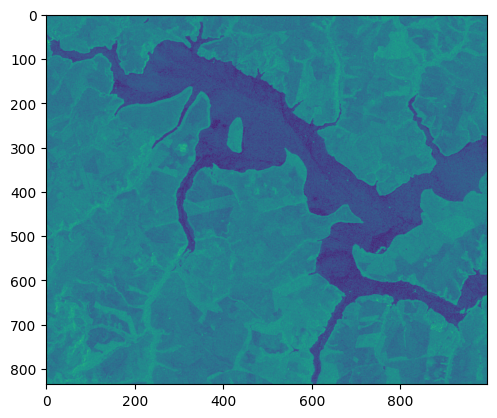

In [18]:
plt.imshow(array)

## Análise temporal

In [19]:
y = desc_vv_collec_rename.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=geom,
    scale=10,
    bestEffort=True,
    maxPixels=1e9
)

In [20]:
y.getInfo().values()

dict_values([-13.47847970784872, -13.38925464454839, -14.811241990798038, -14.133577796358088, -14.753538846044831, -14.318757409915694, -15.30852748714763, -14.172759679155067, -14.81333547818265, -12.826210460710938])

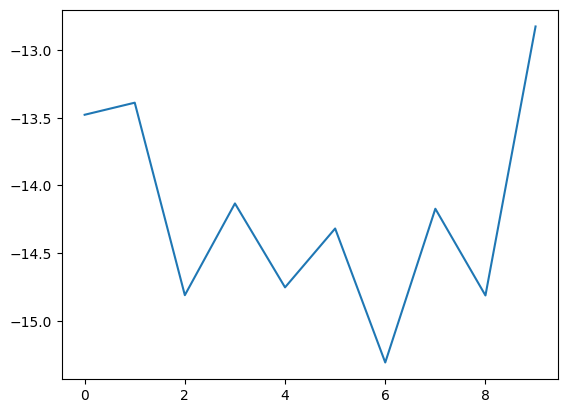

In [21]:
plt.plot(pd.Series(range(0,len(y.getInfo()))), y.getInfo().values())

## Utilizando RPy2

In [24]:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri
import rpy2.robjects as robjects

rpy2.robjects.numpy2ri.activate()
pandas2ri.activate()

In [25]:
astsa = importr('astsa')
base = importr('base')
stats = importr('stats')

In [26]:
time_series = list(y.getInfo().values())
time_series

[-13.47847970784872,
 -13.38925464454839,
 -14.811241990798038,
 -14.133577796358088,
 -14.753538846044831,
 -14.318757409915694,
 -15.30852748714763,
 -14.172759679155067,
 -14.81333547818265,
 -12.826210460710938]

In [27]:
r_time_series = stats.ts(robjects.FloatVector(time_series))
r_time_series

array([-13.47847971, -13.38925464, -14.81124199, -14.1335778 ,
       -14.75353885, -14.31875741, -15.30852749, -14.17275968,
       -14.81333548, -12.82621046])

In [28]:
r_ts_scaled = base.scale(r_time_series)

In [29]:
specenv_res = astsa.specenv(base.cbind(r_ts_scaled, abs(r_ts_scaled), r_ts_scaled**2), real=True, plot=False)

In [30]:
def get_specenv(ar):
    time_series = list(ar)
    r_time_series = stats.ts(robjects.FloatVector(time_series))
    r_ts_scaled = base.scale(r_time_series)
    specenv_res = astsa.specenv(base.cbind(r_ts_scaled, abs(r_ts_scaled), r_ts_scaled**2), real=True, plot=False)
    return specenv_res

In [31]:
get_specenv(time_series)

array([[ 0.1       ,  0.68904684,  0.22743253,  0.85972661, -0.4573233 ],
       [ 0.2       ,  0.18087528,  0.31409164,  0.89105077, -0.3276812 ],
       [ 0.3       ,  0.42678882,  0.11724766,  0.77248992, -0.62410921],
       [ 0.4       ,  0.39441949,  0.32131233, -0.44168935, -0.8376568 ],
       [ 0.5       ,  1.40748082,  0.13247219, -0.89662991,  0.42249961]])

In [33]:
nrows = 1000

coords = df.head(nrows).loc[:,['latitude','longitude']]
df_specenv = df.head(nrows).drop(['latitude', 'longitude'], axis=1)
df_specenv["spec_env"] = df_specenv.apply(get_specenv, axis=1)
df_specenv = df_specenv.join(coords)
df_specenv

,20200503_VV,20200515_VV,20200527_VV,20200608_VV,20200620_VV,20200702_VV,20200714_VV,20200726_VV,20200807_VV,20200819_VV,spec_env,latitude,longitude
0,-17.273153,-14.333942,-14.432971,-10.117658,-13.179768,-10.290556,-17.269129,-14.685134,-12.341894,-13.158760,"[[0.1, 0.4186455957471, 0.035397370916356044, ...",-22.727959,-48.537896
1,-12.688921,-10.923240,-11.849476,-8.400269,-11.743602,-11.960305,-9.052490,-10.638615,-8.999318,-10.629831,"[[0.1, 0.2679729457616334, -0.1125305555607312...",-22.727959,-48.537627
2,-7.281533,-10.338582,-7.750847,-8.122651,-10.222126,-8.309761,-7.004852,-8.554842,-7.717191,-10.329189,"[[0.1, 0.37204166128564375, 0.0960987680536689...",-22.727959,-48.537359
3,-7.201952,-7.682477,-6.900675,-5.871086,-5.093064,-8.854019,-6.849399,-6.968968,-10.173355,-8.107619,"[[0.1, 0.6167306602104826, 0.11341256544552984...",-22.727959,-48.537090
4,-9.628618,-6.454707,-6.528138,-5.848741,-6.809394,-8.219940,-9.248813,-9.799252,-11.593968,-9.069384,"[[0.1, 0.8056589174414902, 0.871833219724697, ...",-22.727959,-48.536822
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-14.912933,-10.745258,-14.907346,-12.670178,-12.186235,-9.572748,-13.725770,-16.128535,-12.930614,-10.859954,"[[0.1, 0.36688335826433727, -0.003419895078401...",-22.727959,-48.270715
996,-13.895402,-11.199379,-13.520891,-13.831289,-12.903963,-11.425024,-14.453852,-14.704138,-15.461591,-9.828090,"[[0.1, 0.7111773044372598, 0.39888411691126674...",-22.727959,-48.270447
997,-14.967400,-14.368494,-14.667011,-12.732732,-10.135875,-16.065536,-12.482322,-13.326901,-14.277564,-11.415839,"[[0.1, 0.35694061024969087, -0.035334359039918...",-22.727691,-48.537896
998,-9.900956,-8.756336,-11.721391,-8.027888,-8.912121,-9.444033,-8.648818,-9.125081,-9.800828,-6.948434,"[[0.1, 0.33002196414131374, 0.0728606262997924...",-22.727691,-48.537627


In [47]:
df_specenv.loc[0,"spec_env"]

array([[ 0.1       ,  0.4186456 ,  0.03539737, -0.86032734,  0.50851145],
       [ 0.2       ,  0.38400587,  0.12802443,  0.82047172, -0.55716774],
       [ 0.3       ,  0.45547497, -0.04140365, -0.82998157,  0.55625204],
       [ 0.4       ,  0.72283878, -0.02045336, -0.89201018,  0.45155231],
       [ 0.5       ,  0.53913273,  0.13386608, -0.86131031,  0.49012694]])

In [61]:
exemplo = robjects.FloatVector(df.drop(['latitude','longitude'], axis=1).iloc[0,:])
exemplo

-17.273153,-14.333942,-14.432971,...,-14.685134,-12.341894,-13.158760


In [66]:
exemplo_score = base.scale(exemplo)
astsa.specenv(base.cbind(exemplo_score, abs(exemplo_score), exemplo_score**2), real=True, plot=False)

array([[ 0.1       ,  0.4186456 ,  0.03539737, -0.86032734,  0.50851145],
       [ 0.2       ,  0.38400587,  0.12802443,  0.82047172, -0.55716774],
       [ 0.3       ,  0.45547497, -0.04140365, -0.82998157,  0.55625204],
       [ 0.4       ,  0.72283878, -0.02045336, -0.89201018,  0.45155231],
       [ 0.5       ,  0.53913273,  0.13386608, -0.86131031,  0.49012694]])

In [68]:
list(df.drop(['latitude','longitude'], axis=1).iloc[0,:])

[-17.273153251553538,
 -14.33394235673038,
 -14.432970543246375,
 -10.11765759218468,
 -13.179768171434297,
 -10.290556077658461,
 -17.269129071740256,
 -14.685133983192259,
 -12.34189358871675,
 -13.158759617212862]